# Lex podcast Audio Data

In [79]:
from moviepy import VideoFileClip
import librosa
from IPython.display import display, Audio
from transformers import pipeline
from datasets import Audio as Datasets_Audio
from datasets import Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from sklearn.metrics import accuracy_score

## Extract Audio

In [ ]:
# video = VideoFileClip('../data/kernel-brain-data-jokes.mp4')
# audio = video.audio
# audio.write_audiofile('../data/kernel-brain-data-audio.wav')

## Classify Audio

In [2]:
audio_file_path = '../data/kernel-brain-data-audio.wav'

In [3]:
data, sample_rate = librosa.load(audio_file_path)

In [4]:
Audio(data=data, rate=sample_rate)

In [5]:
zero_shot_classifier = pipeline(
    task="zero-shot-audio-classification",
    model="laion/clap-htsat-unfused")

Device set to use cuda:0


In [6]:
zero_shot_classifier.feature_extractor.sampling_rate

48000

In [7]:
sample_rate

22050

In [8]:
dataset = Dataset.from_dict({"audio":[data.tolist()]})

In [9]:
dataset["audio"]

[[1.1641532182693481e-10,
  -5.820766091346741e-11,
  5.820766091346741e-11,
  -2.3283064365386963e-10,
  0.0,
  0.0,
  0.0,
  0.0,
  -6.984919309616089e-10,
  0.0,
  1.1641532182693481e-10,
  0.0,
  0.0,
  0.0,
  0.0,
  -3.4924596548080444e-10,
  -3.4924596548080444e-10,
  -4.656612873077393e-10,
  0.0,
  -2.3283064365386963e-10,
  4.656612873077393e-10,
  1.1641532182693481e-10,
  -1.1641532182693481e-10,
  1.1641532182693481e-10,
  -3.2014213502407074e-10,
  -3.4924596548080444e-10,
  -2.3283064365386963e-10,
  -3.4924596548080444e-10,
  -1.1641532182693481e-10,
  -2.3283064365386963e-10,
  -1.4551915228366852e-10,
  -3.4924596548080444e-10,
  0.0,
  -2.3283064365386963e-10,
  -1.7462298274040222e-10,
  1.1641532182693481e-10,
  1.1641532182693481e-10,
  -5.820766091346741e-11,
  -2.3283064365386963e-10,
  0.0,
  0.0,
  -5.820766091346741e-11,
  -1.7462298274040222e-10,
  0.0,
  -1.1641532182693481e-10,
  2.3283064365386963e-10,
  -1.1641532182693481e-10,
  -1.1641532182693481e-10,


In [10]:
def chunk_audio(example, chunk_size=1, sample_rate=sample_rate):
    audio = np.array(example["audio"])  # Convert back to NumPy
    chunk_length = sample_rate * chunk_size  # 5-second chunk size

    # Split into 5-second chunks
    chunks = [audio[i : i + chunk_length] for i in range(0, len(audio), chunk_length)]

    # Ensure chunks are lists for Hugging Face compatibility
    return {"audio_chunk": [chunk.tolist() for chunk in chunks]}

# Apply chunking
chunked_dataset = dataset.map(chunk_audio, batched=False, remove_columns=["audio"])

# Flatten the dataset to get each chunk as an individual entry
chunked_dataset = chunked_dataset.flatten()


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [11]:
len(chunked_dataset['audio_chunk'][0][0]) / sample_rate

1.0

In [12]:
chunked_dataset['audio_chunk'][0][0]

[1.1641532182693481e-10,
 -5.820766091346741e-11,
 5.820766091346741e-11,
 -2.3283064365386963e-10,
 0.0,
 0.0,
 0.0,
 0.0,
 -6.984919309616089e-10,
 0.0,
 1.1641532182693481e-10,
 0.0,
 0.0,
 0.0,
 0.0,
 -3.4924596548080444e-10,
 -3.4924596548080444e-10,
 -4.656612873077393e-10,
 0.0,
 -2.3283064365386963e-10,
 4.656612873077393e-10,
 1.1641532182693481e-10,
 -1.1641532182693481e-10,
 1.1641532182693481e-10,
 -3.2014213502407074e-10,
 -3.4924596548080444e-10,
 -2.3283064365386963e-10,
 -3.4924596548080444e-10,
 -1.1641532182693481e-10,
 -2.3283064365386963e-10,
 -1.4551915228366852e-10,
 -3.4924596548080444e-10,
 0.0,
 -2.3283064365386963e-10,
 -1.7462298274040222e-10,
 1.1641532182693481e-10,
 1.1641532182693481e-10,
 -5.820766091346741e-11,
 -2.3283064365386963e-10,
 0.0,
 0.0,
 -5.820766091346741e-11,
 -1.7462298274040222e-10,
 0.0,
 -1.1641532182693481e-10,
 2.3283064365386963e-10,
 -1.1641532182693481e-10,
 -1.1641532182693481e-10,
 0.0,
 3.4924596548080444e-10,
 -4.6566128730773

In [13]:
candidate_labels = ['laughter', 'silence', 'speech']

In [16]:
Audio(np.array(chunked_dataset['audio_chunk'][0][0]), rate=sample_rate)

In [17]:
classifications = []
for audio in tqdm(chunked_dataset['audio_chunk'][0], desc="Detecting Laughter", ascii="░▒▓█"):
    results = zero_shot_classifier(np.array(audio), candidate_labels=candidate_labels)
    if results[0]['score'] > results[1]['score'] and results[2]['score'] < results[0]['score']:
        classifications.append(results[0])
    elif results[1]['score'] > results[0]['score'] and results[2]['score'] < results[1]['score']:
        classifications.append(results[1])
    else:
        classifications.appen(results[2])

Detecting Laughter: 100%|██████████| 147/147 [00:04<00:00, 31.02it/s]


In [18]:
results

[{'score': 0.6702364087104797, 'label': 'speech'},
 {'score': 0.19219358265399933, 'label': 'laughter'},
 {'score': 0.13756999373435974, 'label': 'silence'}]

In [19]:
classifications

[{'score': 0.5797680616378784, 'label': 'speech'},
 {'score': 0.6439109444618225, 'label': 'laughter'},
 {'score': 0.731730580329895, 'label': 'speech'},
 {'score': 0.8746741414070129, 'label': 'laughter'},
 {'score': 0.6730430126190186, 'label': 'laughter'},
 {'score': 0.7639502882957458, 'label': 'laughter'},
 {'score': 0.6535294651985168, 'label': 'speech'},
 {'score': 0.669640064239502, 'label': 'laughter'},
 {'score': 0.9211487770080566, 'label': 'laughter'},
 {'score': 0.7217249274253845, 'label': 'laughter'},
 {'score': 0.6027034521102905, 'label': 'speech'},
 {'score': 0.8651387095451355, 'label': 'laughter'},
 {'score': 0.7559111714363098, 'label': 'laughter'},
 {'score': 0.594732403755188, 'label': 'speech'},
 {'score': 0.7782525420188904, 'label': 'speech'},
 {'score': 0.6524013876914978, 'label': 'speech'},
 {'score': 0.6106393337249756, 'label': 'speech'},
 {'score': 0.6316737532615662, 'label': 'speech'},
 {'score': 0.545601487159729, 'label': 'silence'},
 {'score': 0.711

In [20]:
len(classifications)

147

In [21]:
x = np.arange(0, len(classifications))

In [ ]:
classifications_df = pd.DataFrame(classifications)

In [24]:
classifications_df['score'].values

array([0.57976806, 0.64391094, 0.73173058, 0.87467414, 0.67304301,
       0.76395029, 0.65352947, 0.66964006, 0.92114878, 0.72172493,
       0.60270345, 0.86513871, 0.75591117, 0.5947324 , 0.77825254,
       0.65240139, 0.61063933, 0.63167375, 0.54560149, 0.71152556,
       0.75528818, 0.79761803, 0.97573096, 0.85717094, 0.43221027,
       0.61238134, 0.82287085, 0.60113853, 0.70532107, 0.7862125 ,
       0.54850739, 0.39124167, 0.91880149, 0.51509559, 0.80848694,
       0.46086735, 0.60716867, 0.74233526, 0.53016698, 0.61963314,
       0.80895841, 0.53246439, 0.76754832, 0.89368564, 0.53651595,
       0.6730718 , 0.88022679, 0.58005083, 0.44190633, 0.59660614,
       0.93078977, 0.57274336, 0.81619489, 0.61616278, 0.915205  ,
       0.84146279, 0.85265565, 0.58769161, 0.8264429 , 0.56362522,
       0.42174098, 0.78879988, 0.96684521, 0.69307387, 0.71491593,
       0.72219175, 0.51064533, 0.95352757, 0.61845076, 0.6363824 ,
       0.59964257, 0.88980925, 0.73632711, 0.56961089, 0.68230

['laughter' 'silence' 'speech']
['red', 'blue', 'green']


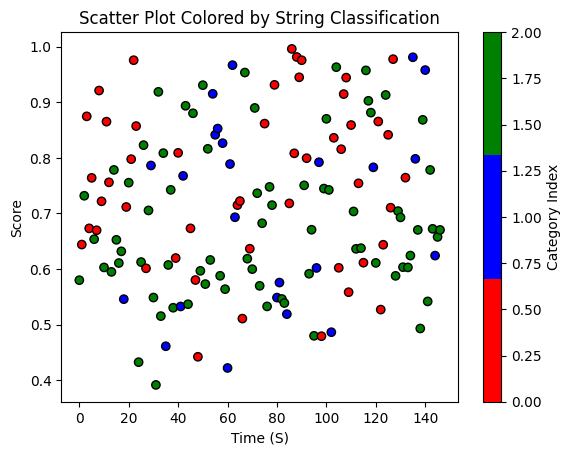

In [25]:
unique_classes = np.unique(classifications_df['label'].values)  # Get unique category labels\
print(unique_classes)
print(["red", "blue", "green"])
color_map = ListedColormap(["red", "blue", "green"])  # Define colors manually

# Convert string labels to integer indices
category_indices = np.array([np.where(unique_classes == cat)[0][0] for cat in classifications_df['label'].values])

# Plot
plt.scatter(x, classifications_df['score'].values, c=category_indices, cmap=color_map, edgecolors="black")
plt.colorbar(label="Category Index")
plt.xlabel("Time (S)")
plt.ylabel("Score")
plt.title("Scatter Plot Colored by String Classification")
plt.show()

In [28]:
classifications_df["label int"] = category_indices

In [29]:
classifications_df

score     label  label int
0    0.579768    speech          2
1    0.643911  laughter          0
2    0.731731    speech          2
3    0.874674  laughter          0
4    0.673043  laughter          0
..        ...       ...        ...
142  0.778209    speech          2
143  0.672209    speech          2
144  0.624031   silence          1
145  0.657647    speech          2
146  0.670236    speech          2

[147 rows x 3 columns]

In [26]:
category_indices

array([2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 1, 0, 2, 0,
       0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 1, 2,
       2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 0,
       0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 1, 1, 2, 2, 1, 0, 0, 0,
       0, 0, 0, 2, 0, 2, 2, 2, 1, 1, 0, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0,
       0, 2, 2, 0, 2, 0, 2, 2, 2, 1, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2,
       0, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2])

### Visual Classification of Audio

##### Implementing SimpleAudio

In [ ]:
# import time
# import numpy as np
# import ipywidgets as widgets
# from IPython.display import display, Audio
# from pydub import AudioSegment
# import simpleaudio as sa

# # Load the audio file
# audio_path = "input_audio.wav"  # Replace with your audio file
# audio = AudioSegment.from_file(audio_path)

# # Example laughter classification (147 seconds, 1 value per second)
# laughter_classifications = [0, 1, 0, 1, 1, 0, 1] * 21  # Example data

# # Ensure the list matches the audio duration
# num_seconds = min(len(laughter_classifications), int(audio.duration_seconds))

# # Create an interactive text widget to update dynamically
# text_widget = widgets.Label(value="Starting...")

# # Function to update text while playing audio
# def play_audio_with_text():
#     # Play the audio
#     wave_obj = sa.WaveObject.from_wave_file(audio_path)
#     play_obj = wave_obj.play()

#     for sec in range(num_seconds):
#         laughter_status = "Laughter" if laughter_classifications[sec] == 1 else "No Laughter"
#         text_widget.value = f"Time: {sec}s - {laughter_status}"
#         time.sleep(1)  # Wait for 1 second

#     play_obj.wait_done()  # Ensure audio playback completes

# # Display widgets
# display(text_widget)

# # Start playback and text update
# play_audio_with_text()


##### Implementing Ipython Display 

In [ ]:
# import time
# import numpy as np
# import ipywidgets as widgets
# from IPython.display import display, Audio
# from pydub import AudioSegment

# # Load the audio file
# audio_path = "../data/kernel-brain-data-audio.wav"  # Replace with your actual audio file
# audio = AudioSegment.from_file(audio_path)

# # Example laughter classification (147 seconds, 1 value per second)
# laughter_classifications = classifications_df["label"].values # Example data
# laughter_confidence = classifications_df['score'].values

# # Ensure the list matches the audio duration
# num_seconds = min(len(laughter_classifications), int(audio.duration_seconds))

# # Create an interactive text widget to update dynamically
# text_widget = widgets.Label(value="Starting...")

# # Function to update text while audio plays
# def update_text():
#     for sec in range(num_seconds):
#         laughter_status = "Laughter" if laughter_classifications[sec] == 1 else "No Laughter"
#         text_widget.value = f"Time: {sec}s - {laughter_status}"
#         time.sleep(1)  # Update text every second

# # Display widgets
# display(text_widget)

# # Display audio player (user must manually play it)
# display(Audio(audio_path))

# # Start the text updates (runs in sync but does not control audio)
# update_text()


##### Implementing Sounddevice

'speech'

In [57]:
import time
import numpy as np
import ipywidgets as widgets
import sounddevice as sd
import wave
from IPython.display import display

# Load laughter classification data
laughter_classifications = classifications_df['label int']

# Load and play the audio
audio_path = "../data/kernel-brain-data-audio.wav"
wav_file = wave.open(audio_path, 'rb')
fs = wav_file.getframerate()
audio_data = np.frombuffer(wav_file.readframes(wav_file.getnframes()), dtype=np.int16)


In [56]:
wav_file.getframerate()

44100

In [58]:
fs

44100

In [62]:
int(wav_file.getnframes() / fs)

146

##### Calculating accuracy of classifier

In [106]:
# Ground Truth of Laughter
ground_truth = [7, 12, 63, 66, 77, 85, 86, 87, 88, 89, 90, 106, 107, 108, 109, 110]

In [107]:
laughter_pred = classifications_df["label"][classifications_df["label"]=="laughter"].index.values

In [108]:
laughter_pred

array([  1,   3,   4,   5,   7,   8,   9,  11,  12,  19,  21,  22,  23,
        27,  39,  40,  45,  47,  48,  64,  65,  66,  69,  75,  79,  85,
        86,  87,  88,  89,  90,  92,  98, 103, 105, 106, 107, 108, 109,
       110, 113, 115, 121, 122, 123, 125, 126, 127, 132])

In [109]:
size = 147
# Create a zero array
ground_truth_bin = np.zeros(size, dtype=int)

# Set specified indices to 1
np.put(ground_truth_bin , ground_truth, 1)

In [110]:
# Create a zero array
laughter_pred_bin = np.zeros(size, dtype=int)

# Set specified indices to 1
np.put(laughter_pred_bin , laughter_pred, 1)

In [111]:
laughter_zero_shot_accuracy = accuracy_score(ground_truth_bin, laughter_pred_bin)
laughter_zero_shot_accuracy*=100

In [112]:
laughter_zero_shot_accuracy


74.82993197278913

In [113]:
print(f"Zero-Shot Classifier is {laughter_zero_shot_accuracy:.2f}%% accurate.")

Zero-Shot Classifier is 74.83%% accurate.


In [114]:
# Create text widget
text_widget = widgets.Label(value="Starting...")

# Function to update text dynamically while playing audio
def play_audio_with_text():
    sd.play(audio_data, samplerate=fs*2)  # Play the audio

    for sec in range(min(len(laughter_classifications), int(wav_file.getnframes() / fs))):
        # if classifications_df['label'][sec] == 'laughter':
        if ground_truth_bin[sec] == 1: # implementing human-labeling rather than the classifier
            text_widget.value = f"Time: {sec}s \nClassification: {classifications_df['label'][sec]} \n Confidence: {classifications_df['score'][sec]}"
        else:
            text_widget.value = f""
        time.sleep(1)  # Wait for 1 second

    sd.stop()  # Stop playback when done

# Display text widget
display(text_widget)

# Start playback and text update
play_audio_with_text()


Label(value='Starting...')

In [116]:
# 1 indicates the presence of laughter while 0 indicates no laughter.
ground_truth_bin

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Visual Overlay of Classification

In [94]:

# import cv2
# import numpy as np
# import moviepy.editor as mp

# # Load video
# video_path = "input.mp4"
# output_path = "output.mp4"
# video = mp.VideoFileClip(video_path)

# # Get video properties
# fps = video.fps
# width, height = video.size

# # Example: List of laughter classifications for each second (1 = laughter, 0 = no laughter)
# laughter_classifications = [0, 1, 0, 1, 1, 0, 1] * 21  # Example, should be 147 values

# # Ensure the list matches video duration
# num_seconds = min(len(laughter_classifications), int(video.duration))

# # Define function to overlay text on each frame
# def add_text_to_frame(frame, time):
#     overlay = frame.copy()
    
#     # Get laughter classification for the current second
#     sec = int(time)  # Convert time to integer (seconds)
#     if sec < len(laughter_classifications):
#         laughter_status = "Laughter" if laughter_classifications[sec] == 1 else "No Laughter"
#     else:
#         laughter_status = "No Data"

#     # Define text properties
#     text = f"Time: {sec}s - {laughter_status}"
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     font_scale = 1
#     color = (255, 255, 255)  # White text
#     thickness = 2

#     # Position text
#     text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
#     text_x = 10
#     text_y = text_size[1] + 10  # Slight padding from top

#     # Add text to frame
#     cv2.putText(overlay, text, (text_x, text_y), font, font_scale, color, thickness, cv2.LINE_AA)
    
#     return overlay

# # Process each frame to add the text overlay
# def process_frame(frame, t):
#     frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert to OpenCV format
#     frame = add_text_to_frame(frame, t)  # Overlay text
#     return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert back for MoviePy

# # Apply overlay function to each frame
# new_video = video.fl_image(process_frame)

# # Save the final video with the original audio
# new_video.write_videofile(output_path, codec="libx264", audio=True)


### Further 